# Bengali.Al Handwritten Graphemes Classification

## Team: Zzz...
## Members: Cheng Zeng, Zhi Wang, Zhe Huang
#### 03/02/2020

* **1. Introduction**
* **2. Exploratory Data Analysis (EDA)**
* **3. The model (densenet121)**
    * 3.1 Preprocess
    * 3.2 Define the model
    * 3.3 Set the optimizer and learning rate
    * 3.4 Data augmentation
* **4. Evaluate the model**
* **5. Inference and Submission**
* **6. Approaches for Model Improvement**
    * 6.1 Different augmentation methods
    * 6.2 Ensemble prediction
    * 6.3 Increase input size
    * 6.4 More CNN architectures
    * 6.5 Regularization and Initialization 
    * 6.6 Other hyperparameter tuning

--------------------------------------------------------------------------------------------------------------

# 1. Introduction

This midterm project aims to develop a CNN model to classify the three constituent components of Bengali handwritten characters, including grapheme root, vowel diacritics, and consonant diacritics. Identifying characters by optical recognition is challenging since each Bengali has 11 vowels and 38 consonants in its alphabet, and there are 10 potential diacritics. As a result, a large amount of graphemes (the smallest units in a written language) exist. This quickly adds up to more than 10,000 different grapheme variations. This is a Kaggle competition, of which more information can be found in their website ([Kaggle link](https://www.kaggle.com/c/bengaliai-cv19)). This work by Team **Zzz..** now lives on [github](https://github.com/cengc13/Bengali_Kaggle). 

# 2. Exploratory Data Analysis (EDA)

## Overview of the Bengali Grepheme Images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import time, sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

sys.path.append("/content/drive/My Drive/1040_Mid_project/tools")
from helpers import (get_n, get_dummies, resize, image_from_char, 
                     plot_count, display_image_from_data,
                    display_writting_variety, crop_resize)

In [0]:
for dirname, _, filenames in os.walk('/content/drive/My Drive/1040_Mid_project/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/1040_Mid_project/data/.DS_Store
/content/drive/My Drive/1040_Mid_project/data/class_map.csv
/content/drive/My Drive/1040_Mid_project/data/sample_submission.csv
/content/drive/My Drive/1040_Mid_project/data/test.csv
/content/drive/My Drive/1040_Mid_project/data/train_image_data_2.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_3.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_1.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_0.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_1.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_0.parquet
/content/drive/My Drive/1040_Mid_project/data/train.csv
/content/drive/My Drive/1040_Mid_project/data/test_image_data_2.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_3.parquet


We look at the **.csv* files 

### Trainingset 

In [0]:
### training dataframe
DATA_FOLDER = '/content/drive/My Drive/1040_Mid_project/data'
train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
print(train_df.shape)
train_df.head()

(200840, 5)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


Note that the input is the handwritten image (the last column), while the output should be the classes for the corresponding three constituent components. In the *train.csv* file, there are 200,840 training images. 

### Toy testingset

In [0]:
### Testing dataframe
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
print(test_df.shape)
test_df.head()

(36, 3)


,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


The testing images consist of 12 images whose constitutent components are listed as independent rows.

### Class map

In [0]:
### Classes for three components
class_map_df = pd.read_csv(os.path.join(DATA_FOLDER, 'class_map.csv'))
print(class_map_df.shape)
class_map_df.head()

(186, 3)


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


### Submission format

In [0]:
### Example of submission format
sample_submission_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
sample_submission_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


The submission format is smilar to the testing dataset.

### Image pixels

Followed we will discuss the dataformat of the parquet files. We only deal with one of the training and testing parquet file.

In [0]:
train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_0.parquet'))
print(train_0_df.shape)
train_0_df.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,253,254,253,253,253,254,253,252,253,253,253,253,252,252,253,253,252,252,253,252,252,252,253,254,253,253,252,252,252,253,...,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,252,250,250,246,249,248,250,249,251,252,253,253,253,253,253,253,253,250,249,251,252,251,251,251,251,252,253,251,250,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,252,253,252,252,251,250,251,253,254,251,251,252,252,253,253,252,251,251,249,251,252,252,253,252,251,251,251,250,250,252,...,253,253,252,252,252,253,253,253,253,253,252,251,251,250,250,250,251,251,251,250,250,250,251,252,253,253,253,253,254,254,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,250,251,250,249,251,251,251,250,252,251,245,245,251,252,251,252,252,250,249,250,251,250,249,250,251,252,253,252,252,252,...,253,252,252,254,253,253,254,253,252,253,254,253,252,253,254,254,254,254,254,254,254,254,253,252,253,254,253,252,253,254,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,225,231,229,229,228,221,224,226,221,221,220,217,217,218,219,222,224,214,218,227,227,227,228,224,231,235,235,233,212,183,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


Each train_image_data_x (x = 0...3) contains 50210 rows and 32333 columns - size of each image being: (137, 236). Totally there are 50210 x 4 = 200840 rows in the training set, in consistent the number of images in the train.csv file. Each feature corresponds to a pixel of the image. The values are in the range of $[0,255]$.

#### Pixel distribution

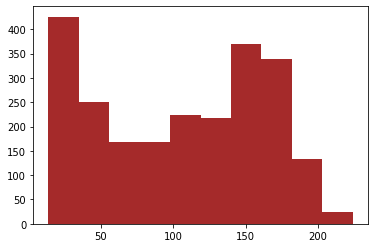

In [0]:
pixels_train_0 = 255 - train_0_df.iloc[7, 1:].values
plt.hist(pixels_train_0[pixels_train_0 > 13], color='brown');

## Data distribution 

### Number of Unique values 

In [0]:
print(f"Train: unique grapheme roots: {train_df.grapheme_root.nunique()}")
print(f"Train: unique vowel diacritics: {train_df.vowel_diacritic.nunique()}")
print(f"Train: unique consonant diacritics: {train_df.consonant_diacritic.nunique()}")
print(f"Train: total unique elements: {train_df.grapheme_root.nunique() + train_df.vowel_diacritic.nunique() + train_df.consonant_diacritic.nunique()}")
print(f"Class map: unique elements: \n{class_map_df.component_type.value_counts()}")
print(f"Total combinations: {pd.DataFrame(train_df.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])).shape[0]}")

Train: unique grapheme roots: 168
Train: unique vowel diacritics: 11
Train: unique consonant diacritics: 7
Train: total unique elements: 186
Class map: unique elements: 
grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64
Total combinations: 1292


### Class frequency analysis

####  Top 20 Grapheme roots and their percentages in training set

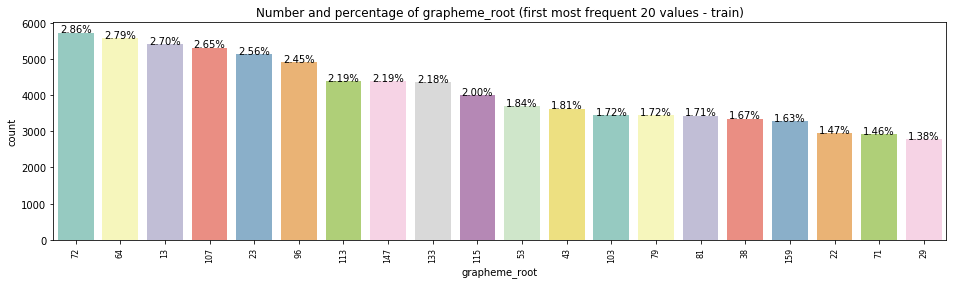

In [0]:
plot_count('grapheme_root', 'grapheme_root (first most frequent 20 values - train)', train_df, size=4)

####  Vowel diacritic percentages in the trainingset

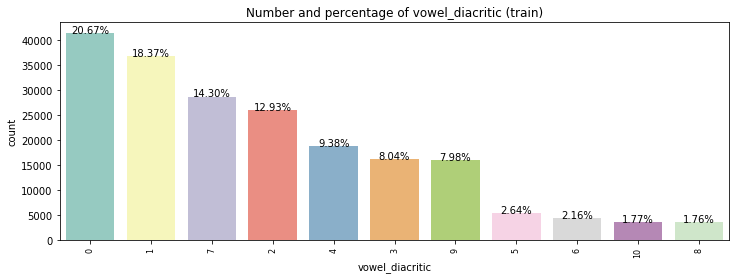

In [0]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df, size=3)

####  Consonant diacritic percentages in the trainingset

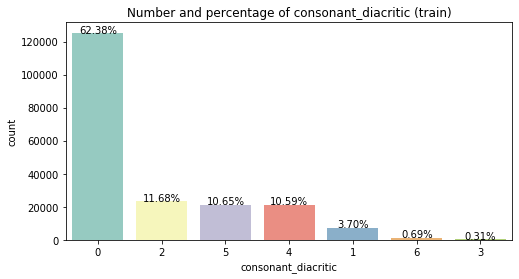

In [0]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', train_df, size=2)

According to the bar plots, the grapheme roots are more evenly distributed than both vowel diacritics and consonant diascritcs. Vowel diacritics tend to concentrate on class 0, 1, 7 and 2, whereas most of cosonant diacritics (more than 60\%) fall into class 0. 

##  Inspecting training images

###  25 randomly sampled images

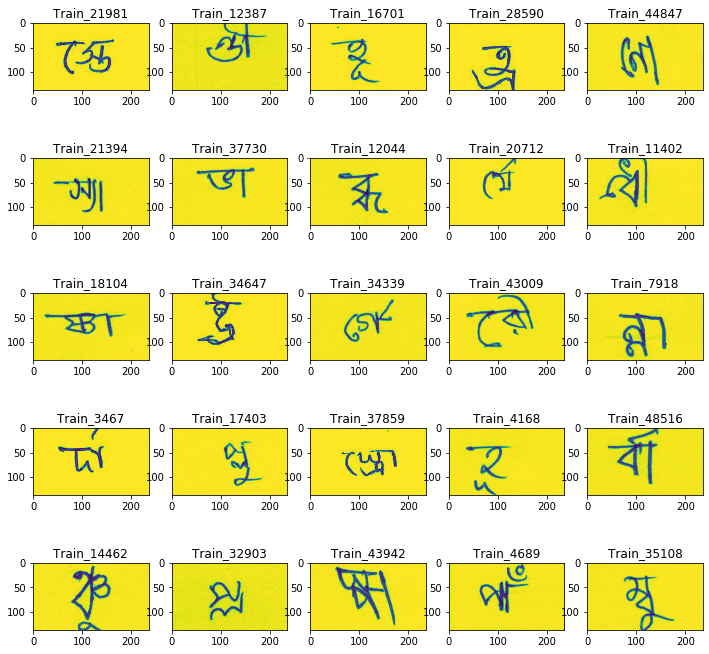

In [0]:
display_image_from_data(train_0_df.sample(25, random_state=42))

###  Studying writing variety

total: (163, 5)
total: (36, 32333)
grapheme: দাঁ, grapheme root: দ, vowel discritic: া, consonant diacritic: ঁ


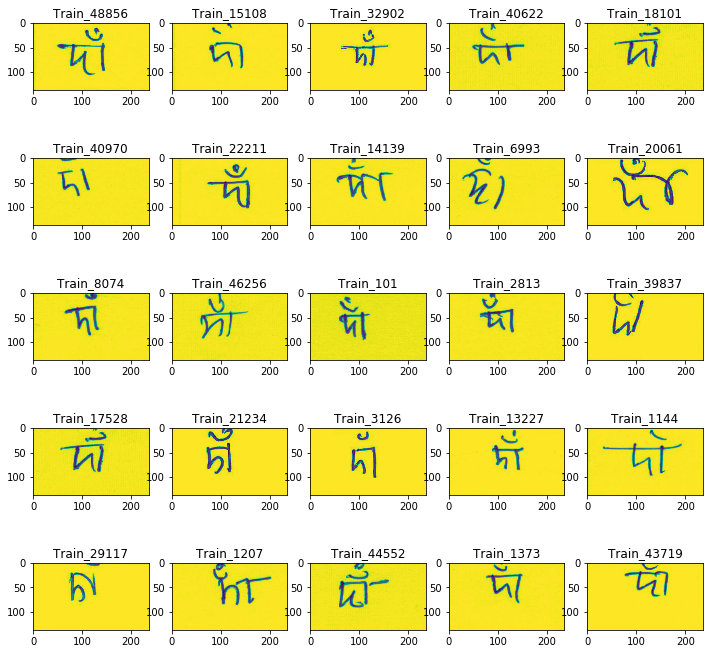

In [0]:
display_writting_variety(train_0_df,train_df, class_map_df,72,1,1,5)

##  Image crop and resize

Compare the resize methods provided in the `opencv` package and the resize method written by [lafoss](https://www.kaggle.com/iafoss/image-preprocessing-128x128). Both methods use the first eight images in training set for presentation.

### Methods by lafoss

In [0]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

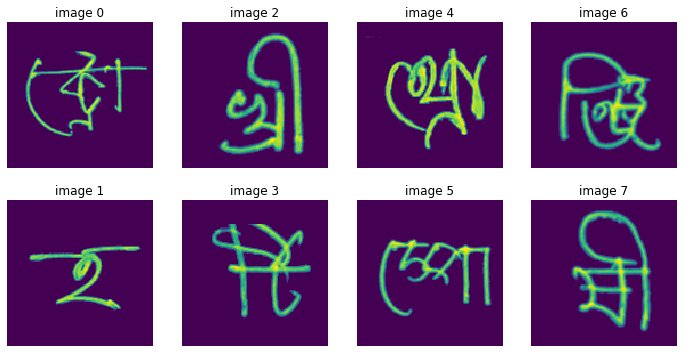

In [0]:
n_imgs = 8
fig, axs = plt.subplots(2, n_imgs//2, figsize=(n_imgs*1.5, 6))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - train_0_df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img, size=SIZE)

    axs[idx%2, idx//2].imshow(img)
    axs[idx%2, idx//2].set_title('image '+str(idx))
    axs[idx%2, idx//2].axis('off')
plt.show()

Check the pixel distribution after crop and resize

(array([387., 285., 244., 281., 279., 315., 518., 457., 220.,  60.]),
 array([ 14. ,  36.9,  59.8,  82.7, 105.6, 128.5, 151.4, 174.3, 197.2,
        220.1, 243. ]),
 <a list of 10 Patch objects>)

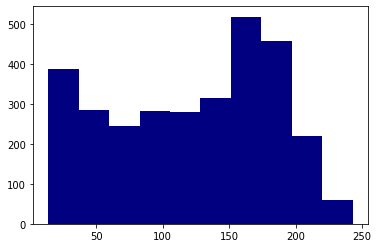

In [0]:
arrayvalues = img.reshape(-1)
plt.hist(arrayvalues[arrayvalues > 13], color='navy')

In [0]:
train_df = train_df.drop(['grapheme'], axis=1, inplace=False)

In [0]:
train_df_new = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{0}.parquet')[:10], 
                    train_df, on='image_id').drop(['image_id'], axis=1)

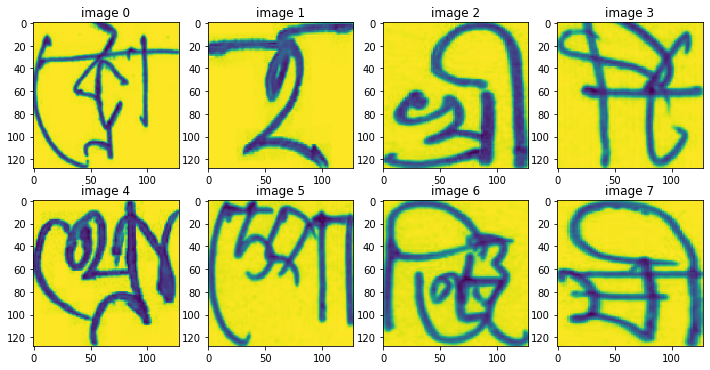

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
count=0
for row in ax:
    for col in row:
        col.imshow(resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], size=SIZE, 
                          plain=False, need_progress_bar=False)\
                   .values.reshape(-1).reshape(SIZE, SIZE).astype(np.float64))
        col.set_title("image " + str(count))
        count += 1
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([640., 319., 253., 257., 299., 314., 385., 847., 605.,  99.]),
 array([ 14. ,  37.1,  60.2,  83.3, 106.4, 129.5, 152.6, 175.7, 198.8,
        221.9, 245. ]),
 <a list of 10 Patch objects>)

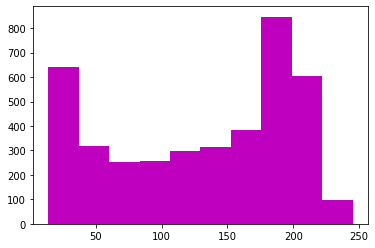

In [0]:
array_7 = 255 - resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], 
       size=128, plain=False, need_progress_bar=False)
plt.hist(array_7[array_7 > 13], color='m')

As we can see, both resize methods are relible since the figures after crop and resize look normal and the original pixel distribution is mostly preserved.

# 3. The model

In [0]:
%tensorflow_version 2.x 
# On Colab, need this to specify tensorflow version
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import time, gc, sys
import cv2

DATA_FOLDER = "/content/drive/My Drive/1040_Mid_project/data"
directory = "/content/drive/My Drive/1040_Mid_project/tools"
sys.path.append(directory)
from helpers import (get_n, get_dummies, resize, plot_loss,
                     MultiOutputDataGenerator, plot_acc,
                    image_from_char)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Activation, Concatenate
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import RandomNormal
# you can import different NN architectures here
from tensorflow.keras.applications import DenseNet121, DenseNet169
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
import os
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/1040_Mid_project/data/.DS_Store
/content/drive/My Drive/1040_Mid_project/data/class_map.csv
/content/drive/My Drive/1040_Mid_project/data/sample_submission.csv
/content/drive/My Drive/1040_Mid_project/data/test.csv
/content/drive/My Drive/1040_Mid_project/data/train_image_data_2.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_3.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_1.parquet
/content/drive/My Drive/1040_Mid_project/data/train_image_data_0.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_1.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_0.parquet
/content/drive/My Drive/1040_Mid_project/data/train.csv
/content/drive/My Drive/1040_Mid_project/data/test_image_data_2.parquet
/content/drive/My Drive/1040_Mid_project/data/test_image_data_3.parquet


In [0]:
train_df_ = pd.read_csv(DATA_FOLDER+'/train.csv')
test_df_ = pd.read_csv(DATA_FOLDER + '/test.csv')
class_map_df = pd.read_csv(DATA_FOLDER + '/class_map.csv')
sample_sub_df = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [0]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [0]:
# resize image size
#IMG_SIZE=128
 IMG_SIZE=64
N_CHANNELS=1

### 3.1 Preprocess the data

In [0]:
train_df = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{0}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
X_train = resize(X_train, size=IMG_SIZE, plain=False)/255

# CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

print(f'Training images: {X_train.shape}')
print(f'Training labels root: {Y_train_root.shape}')
print(f'Training labels vowel: {Y_train_vowel.shape}')
print(f'Training labels consonants: {Y_train_consonant.shape}')


# Divide the data into training and validation set
x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = \
train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=66)
del train_df
del X_train
del Y_train_root, Y_train_vowel, Y_train_consonant


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


## Densenet121

### 3.2 Define the model

We use densenet121 here, the structure follows:

![densenet121](http://i.imgur.com/oiTdqJL.jpg)

![densenet121_2](https://miro.medium.com/max/2200/1*B0urIaJjCIjFIz1MZOP5YQ.png)





Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 


In [0]:
def build_densenet(SIZE, rate=0.3):
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, 1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)

    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name='root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name='vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name='consonant')(x)

    # model
    model = Model(inputs=input, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])
    
    return model

In [0]:
# drop rate = 0.3
model = build_densenet(SIZE=IMG_SIZE, rate=0.3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
29089792/29084464 [==============================] - 0s 0us/step


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 3)    30          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

### 3.3 Set the optimizer and learning rate

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".


Adam realizes the benefits of both AdaGrad and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.



The metric function "accuracy" is used is to evaluate the performance our model.
This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [0]:
weights = {'root': 0.4, 'vowel': 0.3, 'consonant':0.3}
# lr = 1e-3
# opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
model.compile(optimizer=Adam(lr=0.00016), loss='categorical_crossentropy', 
              loss_weights=weights, metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 

In [0]:
# Learning rate will be half after 3 epochs if accuracy is not increased
lr_scheduler = []
targets = ['root', 'vowel', 'consonant']
for target in targets:
    lr_scheduler.append(ReduceLROnPlateau(monitor=f'{target}_accuracy', 
                                            patience=3,
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001))

# Callback : Save best model
cp = ModelCheckpoint('saved_models/densenet121_128x128_1-rr.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
#                            save_freq = 1,
                           verbose = 0)
# Callback : Early Stop
#es = EarlyStopping(monitor='val_root_accuracy',
                          #mode = 'auto',
                          #patience = 4,
                          #min_delta = 0,
                          #verbose = 1)

cb = [*lr_scheduler, cp]

In [0]:
batch_size = 512
#batch_size = 64
epochs = 30

HEIGHT = 137
WIDTH = 236

### 3.4 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.


By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

For the data augmentation, i choosed to :
   - Randomly rotate some training images by 8 degrees
   - Randomly  Zoom by 15% some training images
   - Randomly shift images horizontally by 15% of the width
   - Randomly shift images vertically by 15% of the height

The improvement is important : 
   - Without data augmentation i obtained the accuracy of 81.85%, 95.02% and 94.95%.
   - With data augmentation i achieved the accuracy of 90.07%, 96.71% and 97.11%.


In [0]:
# Data augmentation for creating more training data
datagen = MultiOutputDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image  
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# 4. Evaluate the model

In [0]:
histories = []


# This will just calculate parameters required to augment the given data. 
datagen.fit(x_train)


# Fit the model
history = model.fit(datagen.flow(x_train, {'root': y_train_root, 'vowel':y_train_vowel, 'consonant': y_train_consonant}, 
                    batch_size=batch_size),
                    epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]),
                    steps_per_epoch=x_train.shape[0] // batch_size, 
                    callbacks=cb)

    
# train for non-augmentation
#history = model.fit(x_train, [y_train_root, y_train_vowel, y_train_consonant], 
                    #epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]),
                    #batch_size = batch_size)


histories.append(history)

# Delete to reduce memory usage
del x_train
del x_test
del y_train_root
del y_test_root
del y_train_vowel
del y_test_vowel
del y_train_consonant
del y_test_consonant
gc.collect()

Epoch 1/30
90/90 [==============================] - 76s 849ms/step - loss: 3.5633 - root_loss: 5.7202 - vowel_loss: 2.2355 - consonant_loss: 2.0153 - root_acc: 0.0152 - vowel_acc: 0.3371 - consonant_acc: 0.3785 - val_loss: 3.3025 - val_root_loss: 5.0751 - val_vowel_loss: 1.9176 - val_consonant_loss: 2.3240 - val_root_acc: 0.0334 - val_vowel_acc: 0.3555 - val_consonant_acc: 0.4302
Epoch 2/30
90/90 [==============================] - 33s 372ms/step - loss: 2.6612 - root_loss: 4.8867 - vowel_loss: 1.2877 - consonant_loss: 1.0677 - root_acc: 0.0675 - vowel_acc: 0.6004 - consonant_acc: 0.6884 - val_loss: 2.6240 - val_root_loss: 4.6235 - val_vowel_loss: 1.5022 - val_consonant_loss: 1.0798 - val_root_acc: 0.0817 - val_vowel_acc: 0.5126 - val_consonant_acc: 0.6990
Epoch 3/30
90/90 [==============================] - 32s 358ms/step - loss: 2.1919 - root_loss: 4.1432 - vowel_loss: 1.0152 - consonant_loss: 0.7671 - root_acc: 0.1384 - vowel_acc: 0.6805 - consonant_acc: 0.7780 - val_loss: 2.0569 - va

19

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['root_acc'], label='train_root_accuracy')
    plt.plot(np.arange(0, epoch), his.history['vowel_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['consonant_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_root_acc'], label='val_root_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_vowel_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_consonant_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

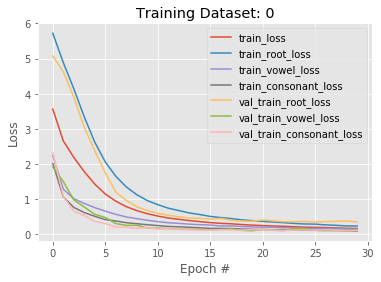

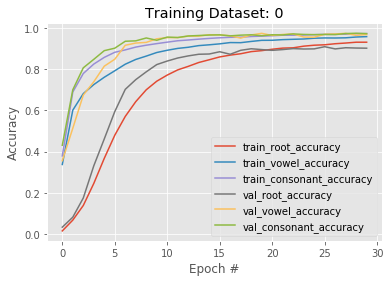

In [0]:
for dataset in range(1):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [0]:
del histories
gc.collect()

# 5. Inference and Submission

In [0]:
import numpy as np
import pandas as pd 
import gc
import cv2
from math import ceil

from tensorflow import keras
from sklearn.model_selection import train_test_split
import os

### Define some parameters
Original image size

In [0]:
WIDTH = 236
HEIGHT = 137

Resized image size

In [0]:
IMG_SIZE=128
N_CHANNELS=1

In [0]:
# batch_size for data generator
BATCH_SIZE = 24
# Dir
DIR = '../data'

In [0]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, X, batch_size = 24, img_size = (128, 128, 1), *args, **kwargs):
        self.X = X
        self.indices = np.arange(len(self.X))
        self.batch_size = batch_size
        self.img_size = img_size
                    
    def __len__(self):
        return int(ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            image = self.X[index]
            image = np.stack((image,)*N_CHANNELS, axis=-1)
            image = image.reshape(-1, HEIGHT_NEW, WIDTH_NEW, N_CHANNELS)
            
            X[i,] = image
        
        return X

In [0]:
# Create Submission File
tgt_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic']

# Create Predictions
row_ids, targets = [], []

In [0]:
### Loop through Test Parquet files (X)
## Do this cell for four times while changing dataset by specifying i = 1, 2, or 3
i = 0 
# Test Files Placeholder
test_files = []

# Read Parquet file
df = pd.read_parquet(os.path.join(DIR, 'test_image_data_'+str(i)+'.parquet'))
# Get Image Id values
image_ids = df['image_id'].values 
# Drop Image_id column
df = df.drop(['image_id'], axis = 1)
df.astype(np.uint8)
# Loop over rows in Dataframe and generate images 
#specify data type as `np.float16` to save memory since default is `np.float64`
X = np.empty([df.shape[0], int(WIDTH_NEW*HEIGHT_NEW)], dtype=np.float16)
for image_id, index in zip(image_ids, range(df.shape[0])):
    test_files.append(image_id)
    roi = resize_image(df.loc[df.index[index]].values, WIDTH_NEW, HEIGHT_NEW)
    X[index,:] = roi
roi = None 
df = None
del roi
del df
gc.collect()

# load the models
trainedmodel2 = "./trainedmodel/densenet121_128x128_2.h5"
trainedmodel1 = "./trainedmodel/densenet121_128x128_1.h5"
model1 = keras.models.load_model(trainedmodel1)
model2 = keras.models.load_model(trainedmodel2)

# Data_Generator
data_generator_test = TestDataGenerator(X, batch_size = BATCH_SIZE, img_size = (HEIGHT_NEW, WIDTH_NEW, N_CHANNELS))

# Predict with two models
preds1 = model1.predict_generator(data_generator_test)
preds2 = model2.predict_generator(data_generator_test)
# preds3 = model3.predict_generator(data_generator_test)

# Loop over Preds
for i, image_id in enumerate(test_files):
    for subi, col in zip(range(len(preds1)), tgt_cols):
        sub_preds1 = preds1[subi]
        sub_preds2 = preds2[subi]
#         sub_preds3 = preds3[subi]

        # Set Prediction with average of 5 predictions
        row_ids.append(image_id+'_'+col)
        ## ensemble prediction
        sub_pred_value = np.argmax(sub_preds1[i] + sub_preds2[i])
#         sub_pred_value = np.argmax(sub_preds1[i])
        targets.append(sub_pred_value)

# Cleanup
data_generator_test = None
preds1 = None
preds2 = None
X = None
del data_generator_test
del preds1
del X
del test_files
gc.collect()

In [0]:
# Create and Save Submission File
submit_df = pd.DataFrame({'row_id':row_ids,'target':targets}, columns = ['row_id','target'])
submit_df.to_csv('submission.csv', index = False)
submit_df.head()

![submission example](https://raw.githubusercontent.com/cengc13/Bengali_Kaggle/master/figures/submission_example.png)

# 6. Approaches for Model Improvement

### 6.1 Different augmentation methods

In [0]:
!pip3 install albumentations==0.4.3
## Function for customized augmentation methods
## shiftscalerotate and cutout are used.
import albumentations as A
def cutout_shiftscalerotate(image):
    if len(image.shape) > 2:
        width, height, _ = image.shape
    else:
        width, height = image.shape
    aug=A.Compose(
        [
         A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, 
        rotate_limit=4, border_mode=cv2.BORDER_REFLECT_101, p=0.6),
        A.Cutout(num_holes=1, max_h_size=width//2, max_w_size=height//2,
             fill_value=1.0, p=0.4)
        ]                     
        )
    image = aug(image=image)['image']
    return image
# make sure you have the latest version 0.4.3, if not 
# update it using '!pip3 install albumentations==0.4.3'
A.__version__

We tried to use more aggressive augmentation methods such as `cutout` to mitigate overfitting issue. It adds improved regularization for the CNN model. It masks out random sections of input images during training. See below for some examples.

![Cutout](https://miro.medium.com/max/682/0*LheHpgaVwsVw2p7L)

### 6.2 Use two model (ensemble) prediction rather than single model prediction

In [0]:
## we put equal weights on the two models since the two models are of similar validation accuracy
sub_pred_value = np.argmax(sub_preds1[i] + sub_preds2[i])

The two single models using `Densenet121` architecture with $128 \times 128 $ input size give public leaderboard (LB) scores of $0.9620$ and $0.9630$. Those two models are only different in the `random_state` for training data splitting. If we combine both models, it can lead to a LB of $0.9657$, about 0.3% increase.  

### 6.3 Increase input image size from $64 \times 64$ to $128 \times 128$

This can increase the public LB score by as much as $\textbf{1}\%$, from around $\textbf{0.95}$ to $\textbf{0.96}$. The top figure indicates resized images with size 64x64, and the bottom plot shows the resized images with size 128x128. With a larger input image size, it makes sense that the accuracy is increased since more information is kept.

![64x64](https://raw.githubusercontent.com/cengc13/Bengali_Kaggle/master/src/features/imagesize64.png)

![128x128](https://raw.githubusercontent.com/cengc13/Bengali_Kaggle/master/src/features/imagesize128.png)

### 6.4 Compare different CNN architectures

We compared the performance using basic CNN model, `Densenet121` and `Densenet169`, `Resnet` and `Efficientnet`. `Basic CNN model` and `Densenet` can give reasonable training accuracy while for `Resnet` and `Efficient`, it is not easy to find a local minima (training is not stable). We finally choose `Densenet121` since its training converges steadily and it gives good accuracy. Note that although `Densenet169` is more dense and has more parameters, we found significant overfitting with this model.

### 6.5 Add $l_1$ regularizer into layers and set the "glorot normal" initializer

In [0]:
# add l1 regularizer into layers 
regularizer = tf.keras.regularizers.l1(1e-3)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

# set the glorot_normal initializer
initializer = keras.initializers.glorot_normal(seed=None)
for layer in model.layers:
    for attr in ['kernel_initializer']:
        if hasattr(layer, attr):
            setattr(layer, attr, initializer)

Adding `initializer` makes the training process more efficient, whereas adding regularizer effectively mitigates the overfitting issue. 

### 6.6 Change the number of dense layers, tune hyperparameters such as kernel size,  learning rate or activation function

Since the training over all datasets are computationally expensive, we only explored a limited region of the the parameter space. We found that these methods does not change the final validation accuracy significantly. We finally used `kernel_size=(3,3)`, initial learning rate of $0.001$ with the `ReduceLROnPlateau` scheduler, and `relu` activation function.

# The best model

Till now, the best model we have is the `Densenet121` with input image size of 128x128, using a combination of shiftscalerotate and cutout as image augmentation, it gives a LB score of 0.9630. We use two models for prediction and submission on Kaggle, and the LB score is 0.9657, slightly better than single model.

## References 

- The `get_n`, `get_dummies`,  `image_from_char`, `plot_acc` and `plot_loss` functions are originated from the kernel by [Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn). The ` MultiOutputDataGenerator` class for multiple output is also from this kernel.
- The image `resize` method is based on the kernel by [Ashadullah Shawon](https://www.kaggle.com/shawon10/bangla-graphemes-image-processing-deep-cnn).
- The code for inference and result submission is heavily adapted from the kernel by [Robin Smits](https://www.kaggle.com/rsmits/keras-efficientnet-b3-training-inference).
- The `crop_resize`,  `plot_count`, `display_image_from_data` and 
    `display_writting_variety` functions are from [Gabriel Preda](https://www.kaggle.com/gpreda/bengali-ai-handwritten-grapheme-getting-started)
- We are also thankful to many useful discussions on Kaggle, for example [Things does not work](https://www.kaggle.com/c/bengaliai-cv19/discussion/130311) and [Things that might work](https://www.kaggle.com/c/bengaliai-cv19/discussion/132118#754943).